In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
sentence = "Snoopy is a beagle"
tokens = sentence.split(" ")
print(tokens)

['Snoopy', 'is', 'a', 'beagle']


### One Hot Encoding

In [5]:
index_word = {i: x for i, x in enumerate(tokens)}
print(index_word)

{0: 'Snoopy', 1: 'is', 2: 'a', 3: 'beagle'}


In [7]:
num_classes = len(index_word)
index_one_hot = {i: tf.one_hot(x, depth=num_classes) for i, x in enumerate(index_word.keys())}
index_one_hot

{0: <tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 0., 0., 0.], dtype=float32)>,
 1: <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 1., 0., 0.], dtype=float32)>,
 2: <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>,
 3: <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 1.], dtype=float32)>}

In [8]:
for k, v in index_one_hot.items():
  word = index_word[k]
  one_hot_vector = v.numpy()
  print(f"{word:<6} : {one_hot_vector}")

Snoopy : [1. 0. 0. 0.]
is     : [0. 1. 0. 0.]
a      : [0. 0. 1. 0.]
beagle : [0. 0. 0. 1.]


### Embeddings

In [11]:
embeddings = tf.random.uniform((4, 2), minval=-0.05, maxval=0.05).numpy()
print(embeddings)

[[ 0.02232567  0.03436811]
 [-0.02511557  0.04496625]
 [ 0.00495315 -0.01438342]
 [-0.0365274   0.01483145]]


In [12]:
snoopy_vec = index_one_hot[0]
beagle_vec = index_one_hot[3]
snoopy_vs_beagle = tf.sqrt(tf.reduce_sum(tf.square(snoopy_vec - beagle_vec)))
print(snoopy_vs_beagle.numpy())

1.4142135


In [15]:
is_vec = index_one_hot[1]
snoopy_vs_is = tf.sqrt(tf.reduce_sum(tf.square(snoopy_vec - is_vec)))
print(snoopy_vs_is.numpy())

1.4142135


In [16]:
snoopy_vs_beagle = tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[3])))
print(snoopy_vs_beagle.numpy())

0.062011


In [18]:
snoopy_vs_is = tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1])))
print(snoopy_vs_is.numpy())

0.04861062


### Toy Model

In [19]:
sentences = [
    "snoopy dog",
    "milo dog",
    "dumbo elephant",
    "portugal country",
    "brazil country"
]

In [20]:
tokenizer= tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
print(tokenizer.word_index)

{'dog': 1, 'country': 2, 'snoopy': 3, 'milo': 4, 'dumbo': 5, 'elephant': 6, 'portugal': 7, 'brazil': 8}


In [21]:
sequences = tokenizer.texts_to_sequences(sentences)
for x in sequences:
  print(x)

[3, 1]
[4, 1]
[5, 6]
[7, 2]
[8, 2]


In [22]:
VOCAB_SIZE = max(tokenizer.index_word) + 1
print(f"VOCAB_SIZE : {VOCAB_SIZE}")

VOCAB_SIZE : 9


In [23]:
def make_skipgrams():
  train_x, all_labels = [], []
  for sequence in sequences:
    pairs, labels = tf.keras.preprocessing.sequence.skipgrams(
        sequence, VOCAB_SIZE, negative_samples=1.0, window_size = 1, shuffle=True
    )
    train_x.extend(pairs)
    all_labels.extend(labels)

  print(train_x)
  train_x = np.array(train_x)
  all_labels = np.array(all_labels, dtype = np.float32)

  content_words = train_x[:, 0]
  context_words = train_x[:, 1]
  return content_words, context_words, all_labels

In [27]:
# inputs
content_input = tf.keras.layers.Input(shape=(1, ), dtype=tf.int32, name="content_word")
context_input = tf.keras.layers.Input(shape=(1, ), dtype=tf.int32, name="context_word")

# layers
embeddings = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=2, name="embeddings")
dot_prod = tf.keras.layers.Dot(axes=2, normalize=True, name="dot_product")

# graph
content_embedding = embeddings(content_input)
context_embedding = embeddings(context_input)

cosine_sim = tf.keras.layers.Flatten(name="flatten")(dot_prod([content_embedding, context_embedding]))
dense_out = tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoid_out")(cosine_sim)

# model
model = tf.keras.models.Model(inputs=[content_input, context_input], outputs=[dense_out])

DECAY_RATE = 5e-6
LR = 0.1

optimizer = tf.keras.optimizers.SGD(learning_rate=LR, weight_decay=DECAY_RATE)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

[[3, 1], [1, 4], [3, 5], [1, 3], [4, 1], [1, 4], [1, 4], [4, 3], [5, 6], [6, 5], [5, 4], [6, 7], [2, 6], [7, 2], [7, 6], [2, 7], [2, 8], [2, 7], [8, 2], [8, 5]]
loss: 0.6955
[[1, 3], [3, 5], [1, 5], [3, 1], [1, 4], [4, 8], [4, 1], [1, 6], [5, 6], [5, 7], [6, 6], [6, 5], [7, 1], [2, 7], [2, 8], [7, 2], [8, 2], [2, 8], [2, 8], [8, 5]]
loss: 0.6658
[[3, 1], [3, 3], [1, 1], [1, 3], [1, 2], [4, 1], [1, 4], [4, 6], [6, 3], [5, 4], [5, 6], [6, 5], [2, 1], [7, 8], [2, 7], [7, 2], [8, 2], [8, 7], [2, 3], [2, 8]]
loss: 0.6772
[[1, 3], [3, 1], [1, 3], [3, 6], [4, 1], [1, 4], [4, 3], [1, 4], [5, 1], [6, 5], [5, 6], [6, 3], [2, 7], [7, 2], [7, 3], [2, 6], [8, 6], [2, 8], [2, 8], [8, 2]]
loss: 0.6447
[[1, 3], [1, 3], [3, 5], [3, 1], [4, 1], [1, 8], [4, 4], [1, 4], [5, 6], [6, 5], [5, 6], [6, 6], [2, 7], [7, 2], [7, 7], [2, 5], [8, 5], [8, 2], [2, 7], [2, 8]]
loss: 0.6772
[[3, 1], [1, 3], [3, 5], [1, 7], [1, 4], [4, 4], [1, 7], [4, 1], [5, 7], [6, 7], [6, 5], [5, 6], [7, 2], [7, 6], [2, 8], [2, 7], [

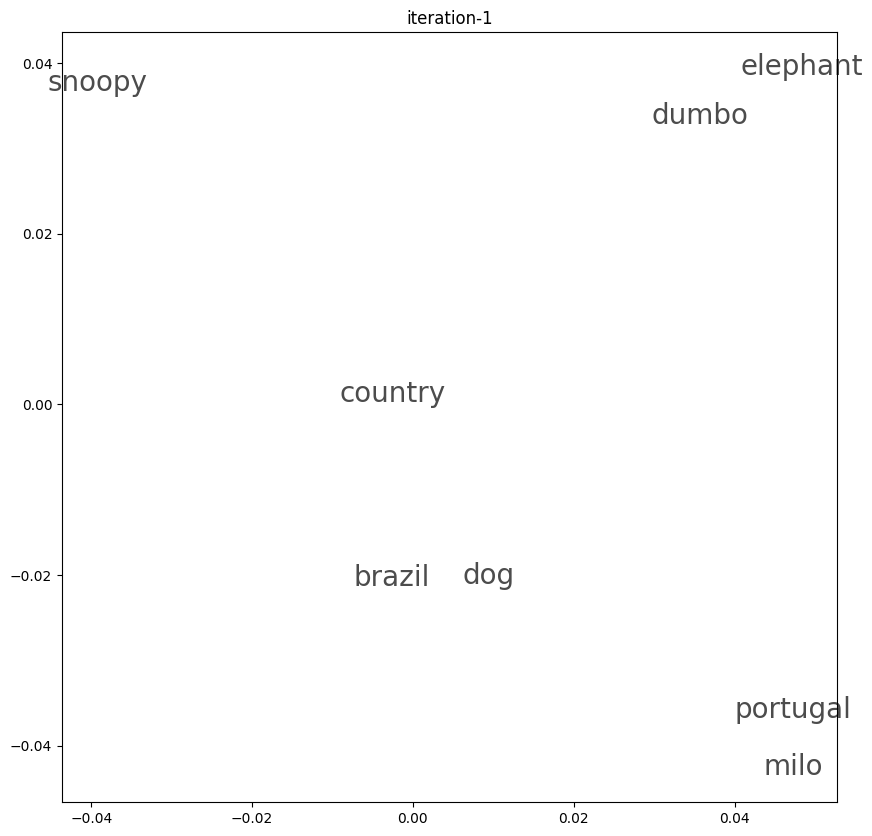

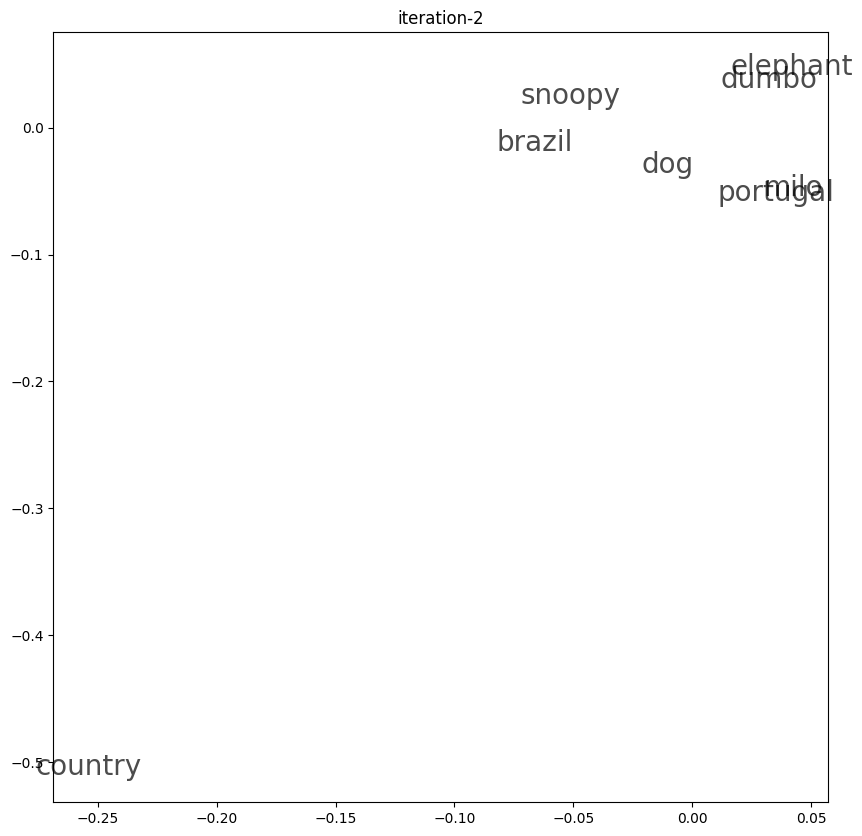

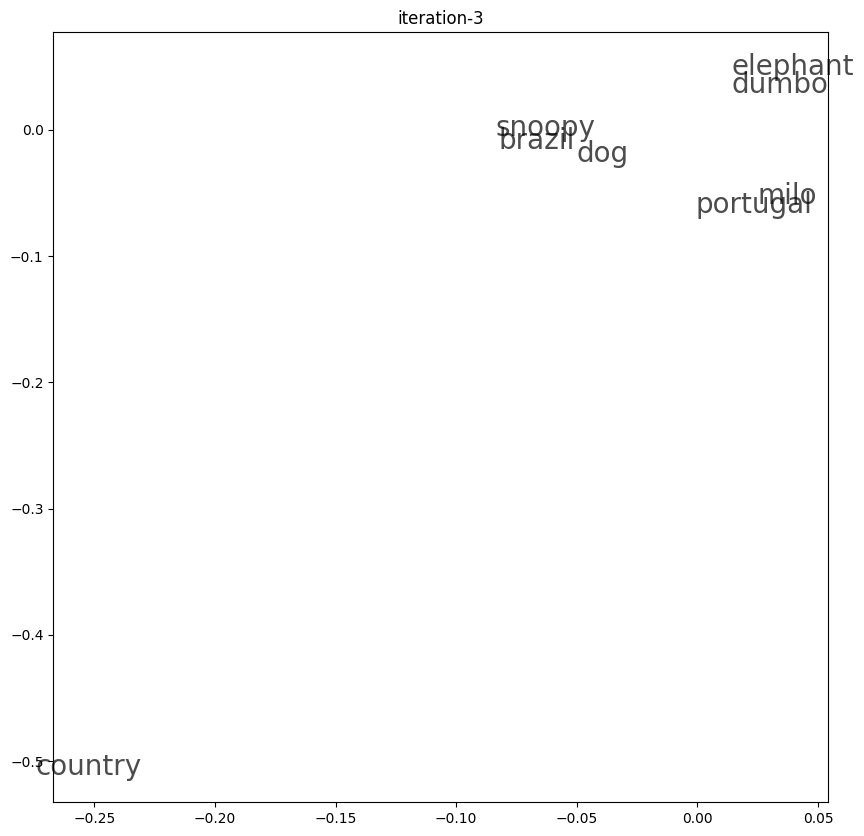

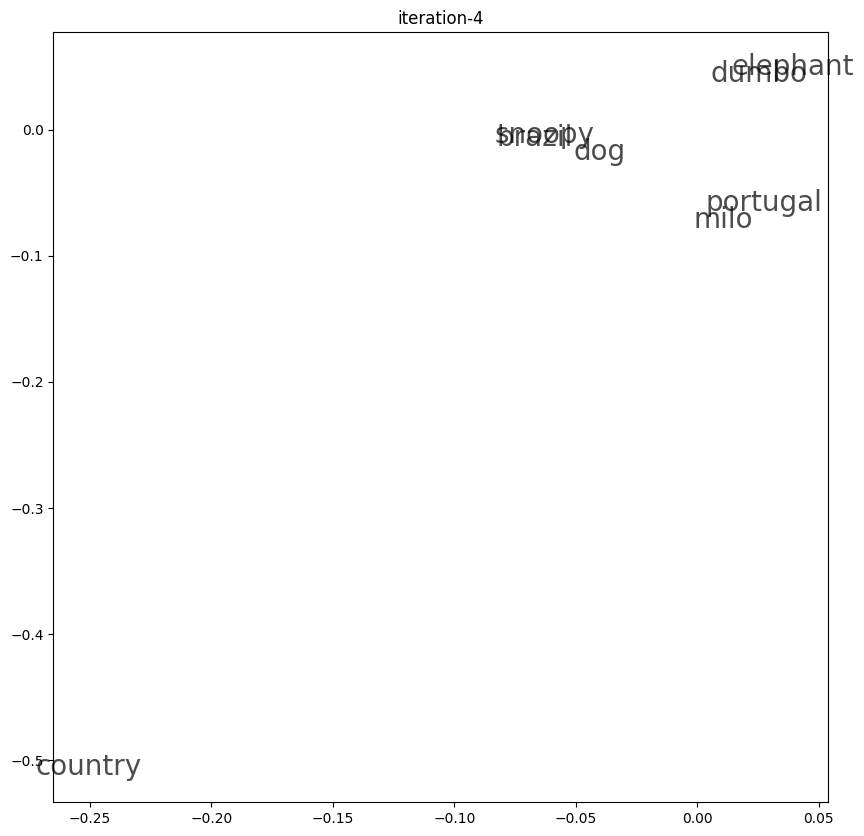

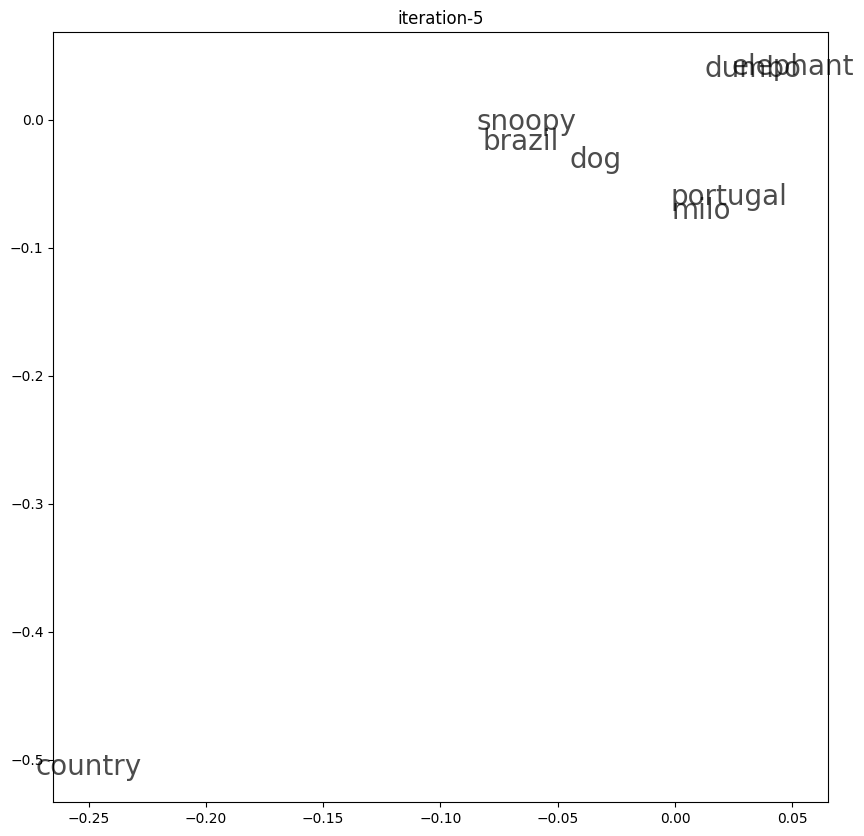

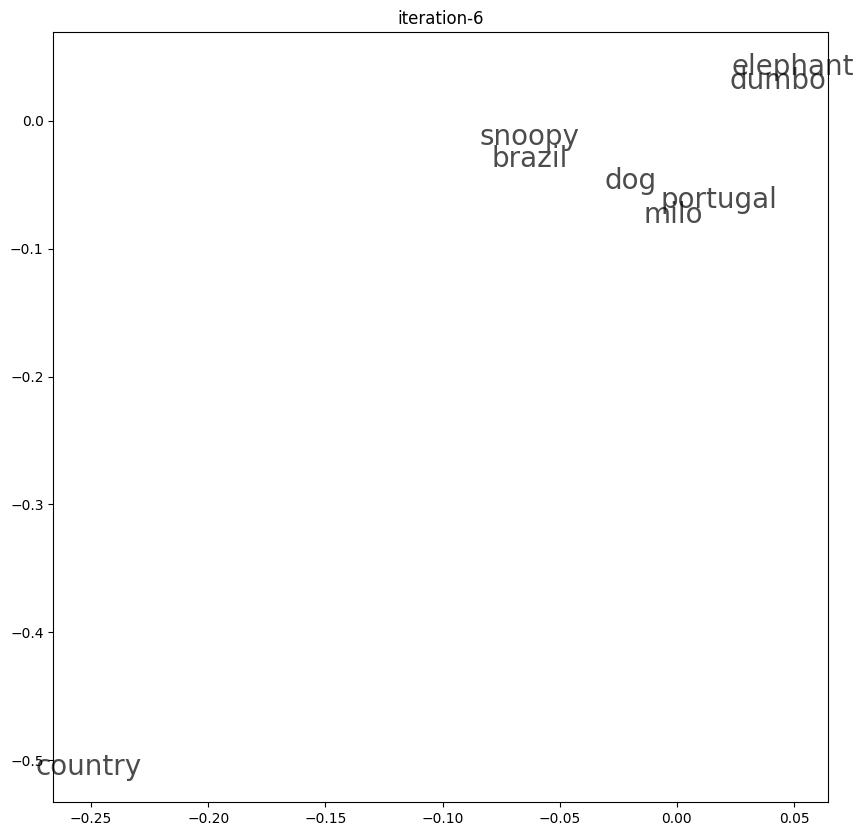

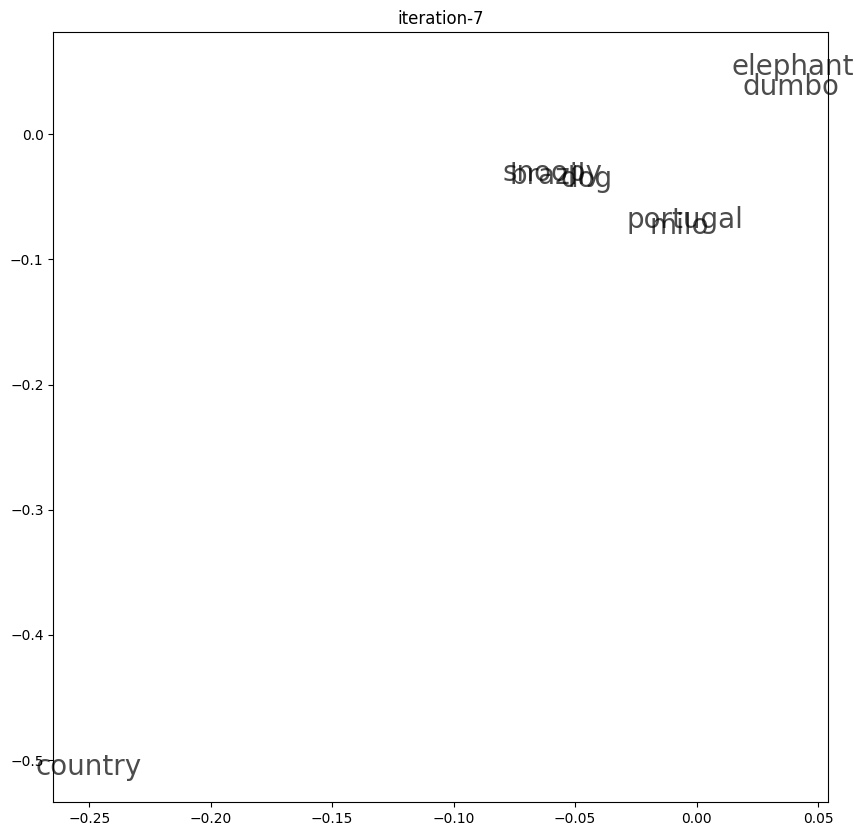

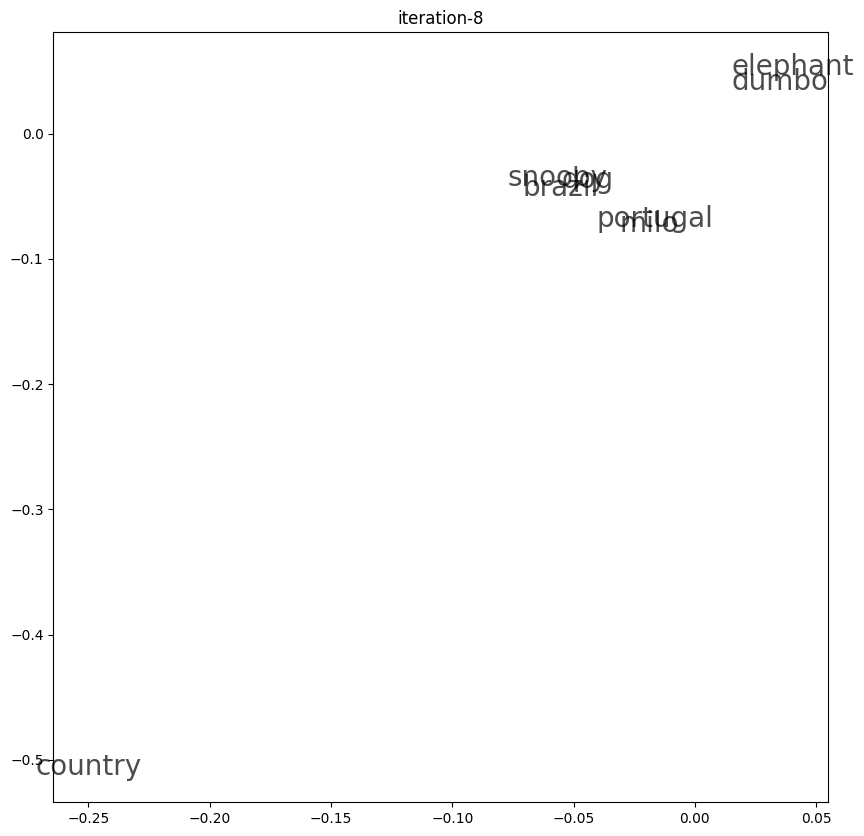

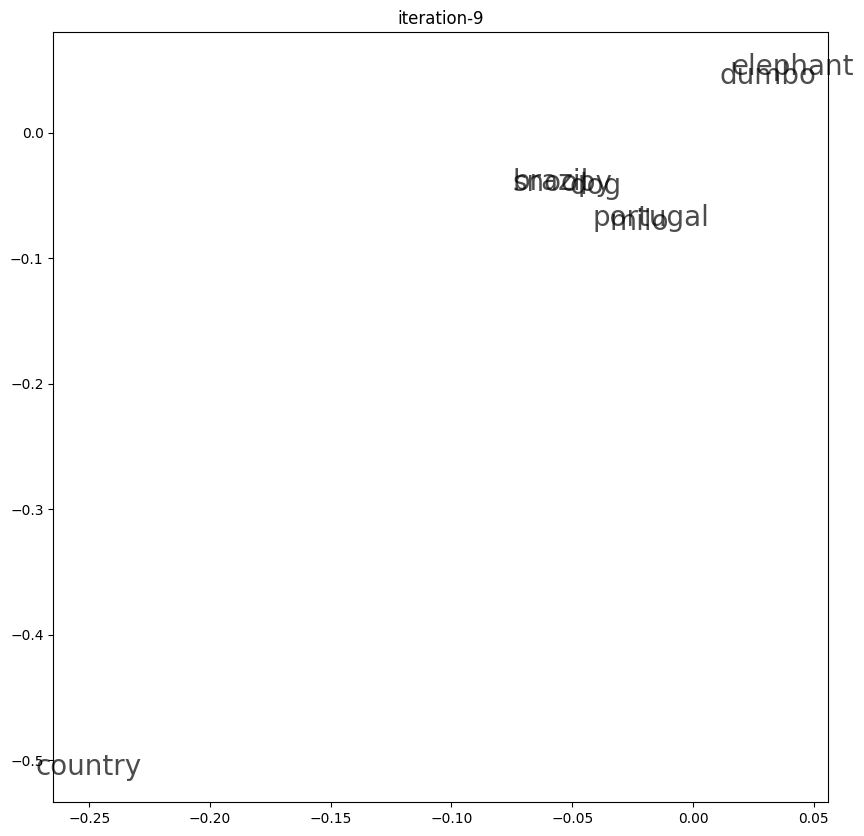

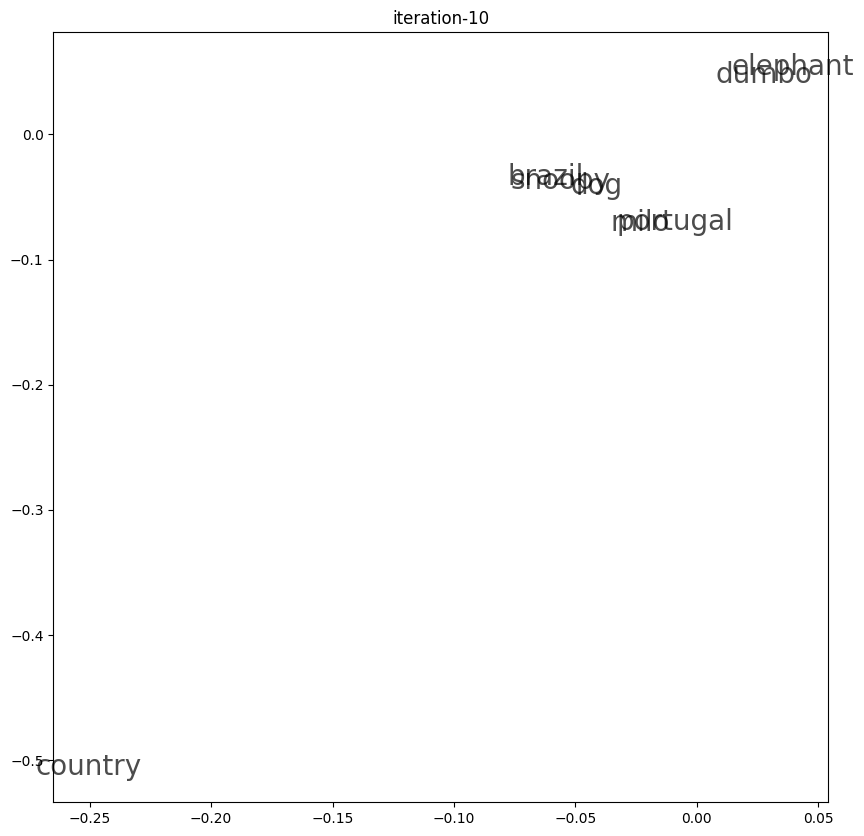

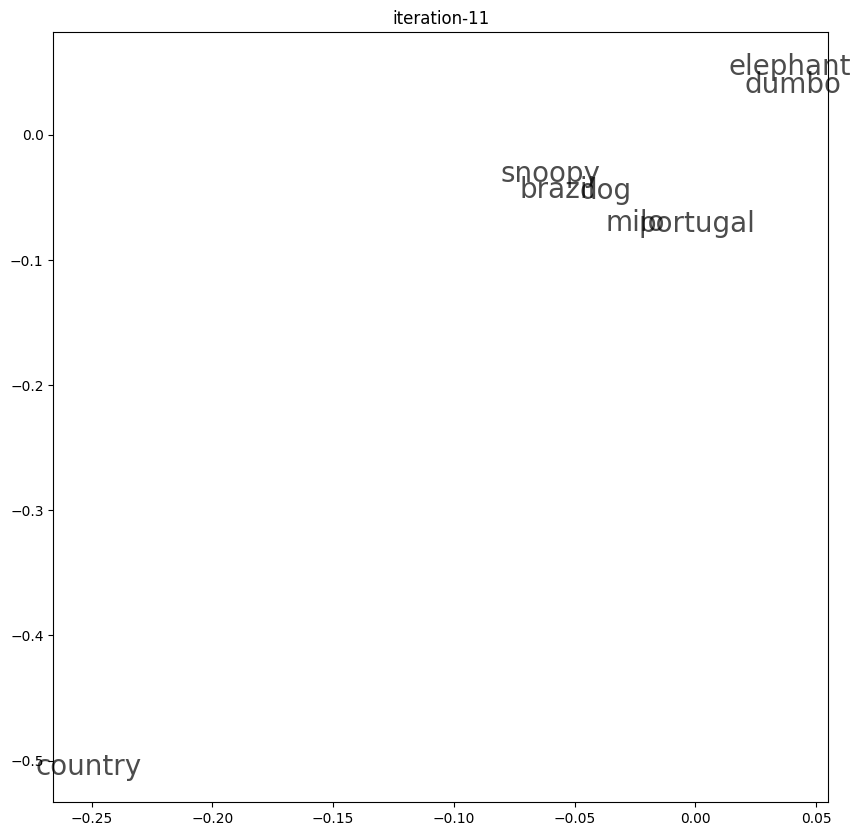

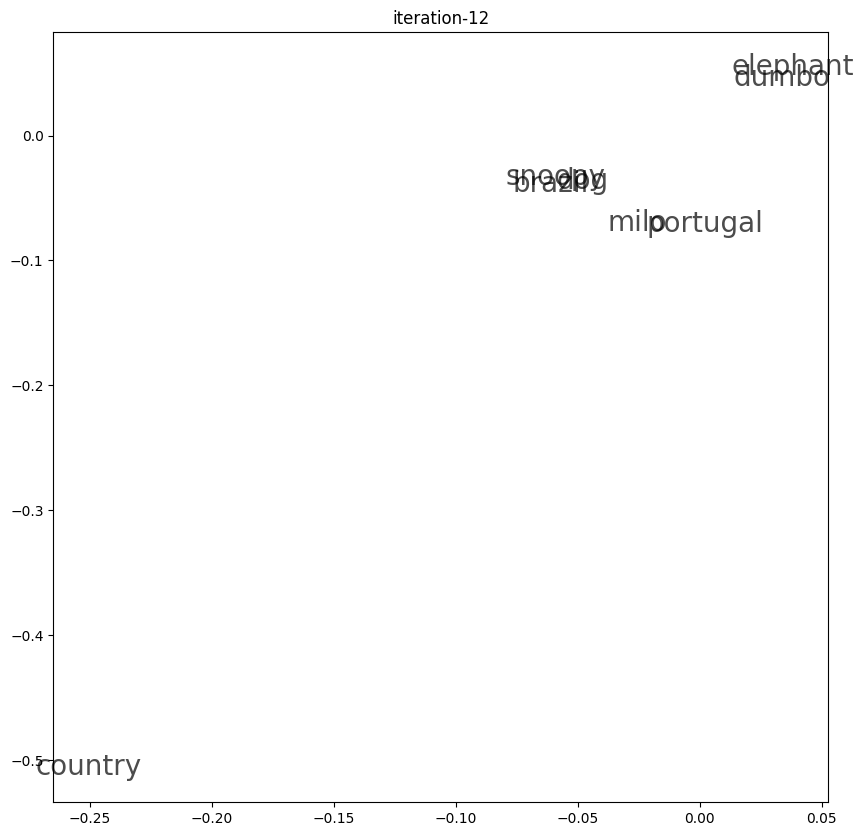

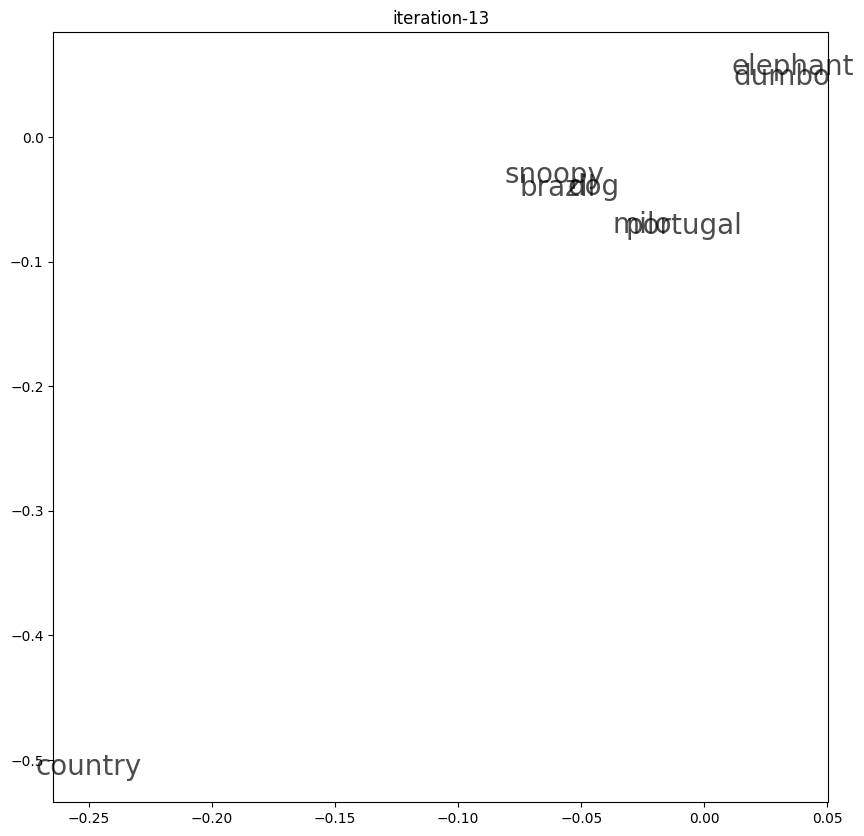

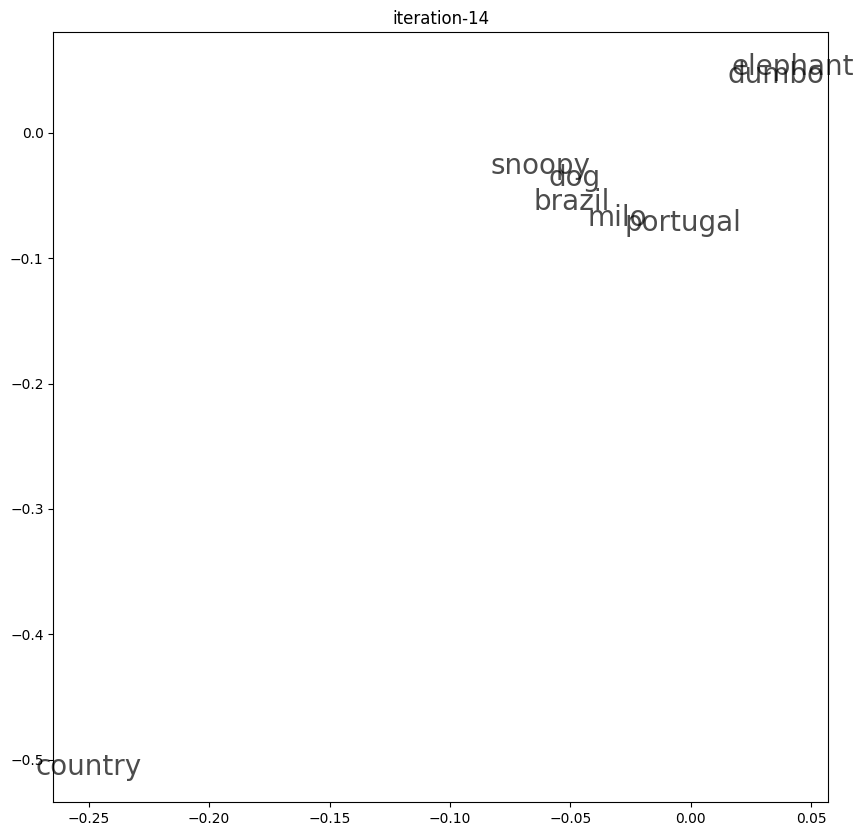

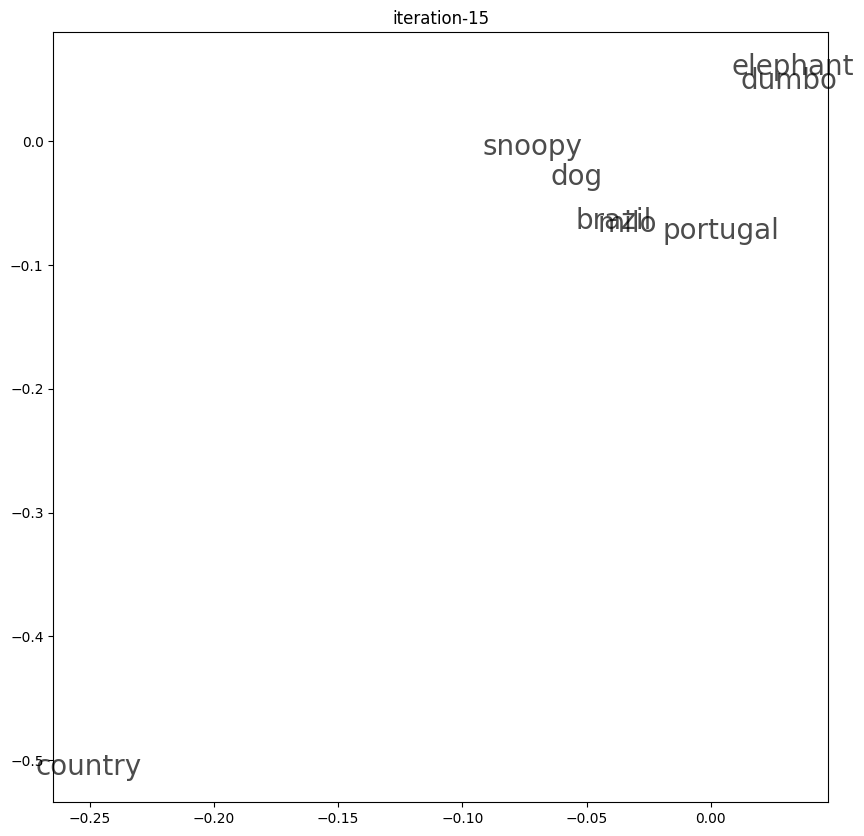

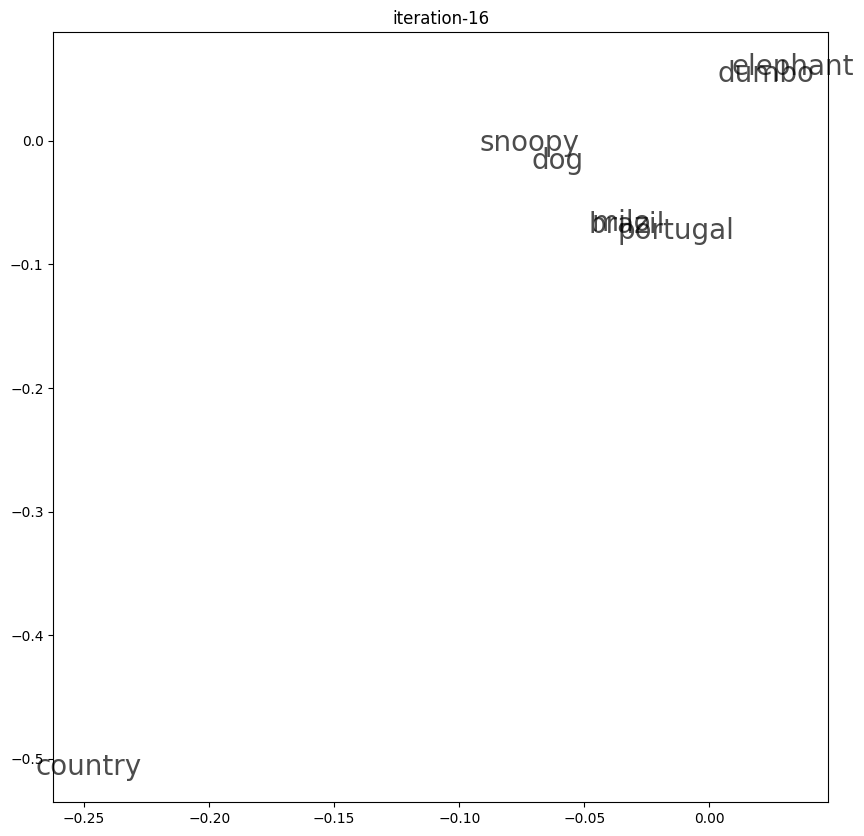

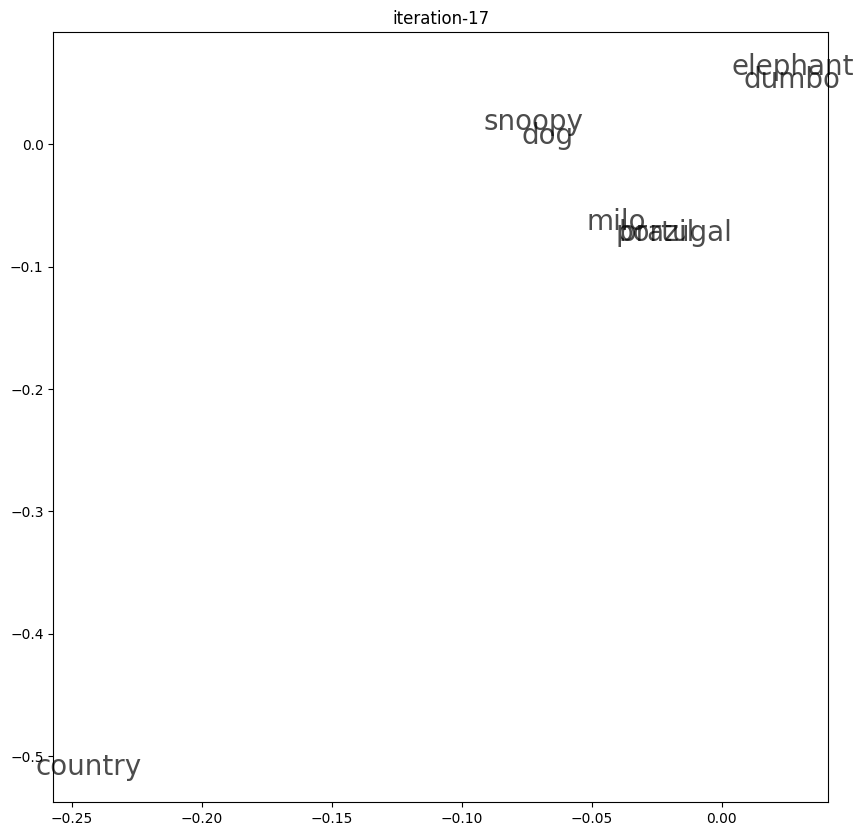

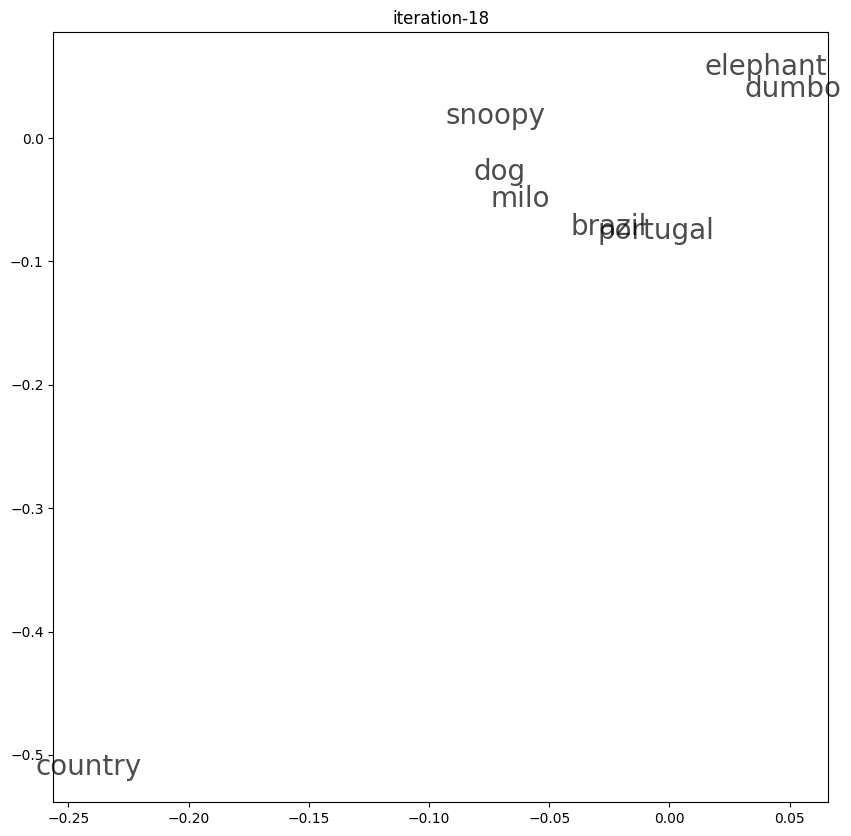

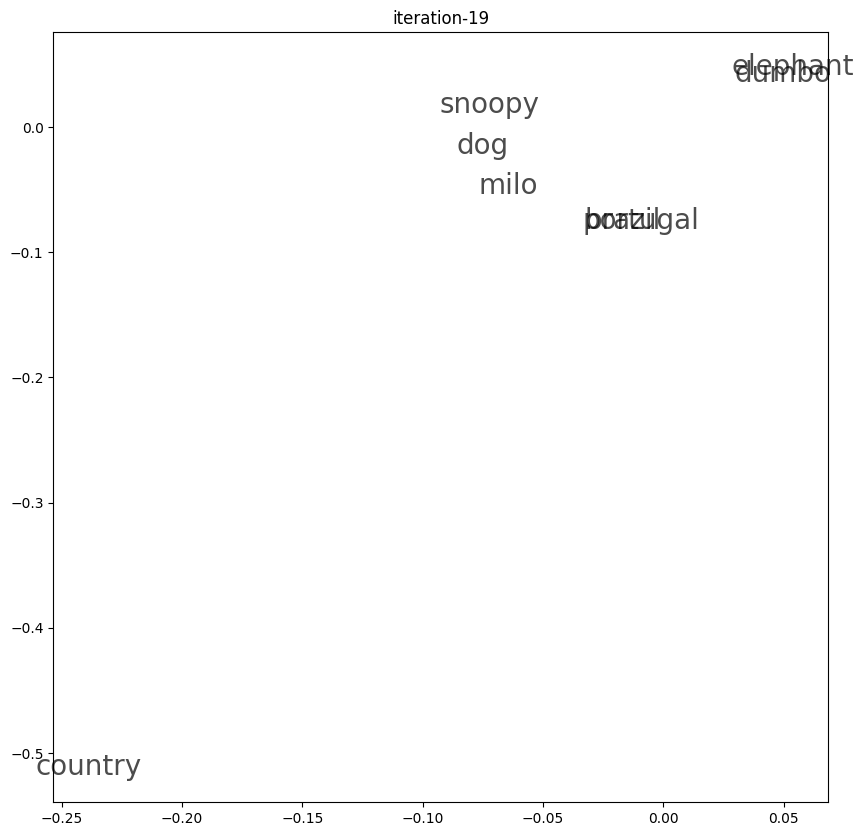

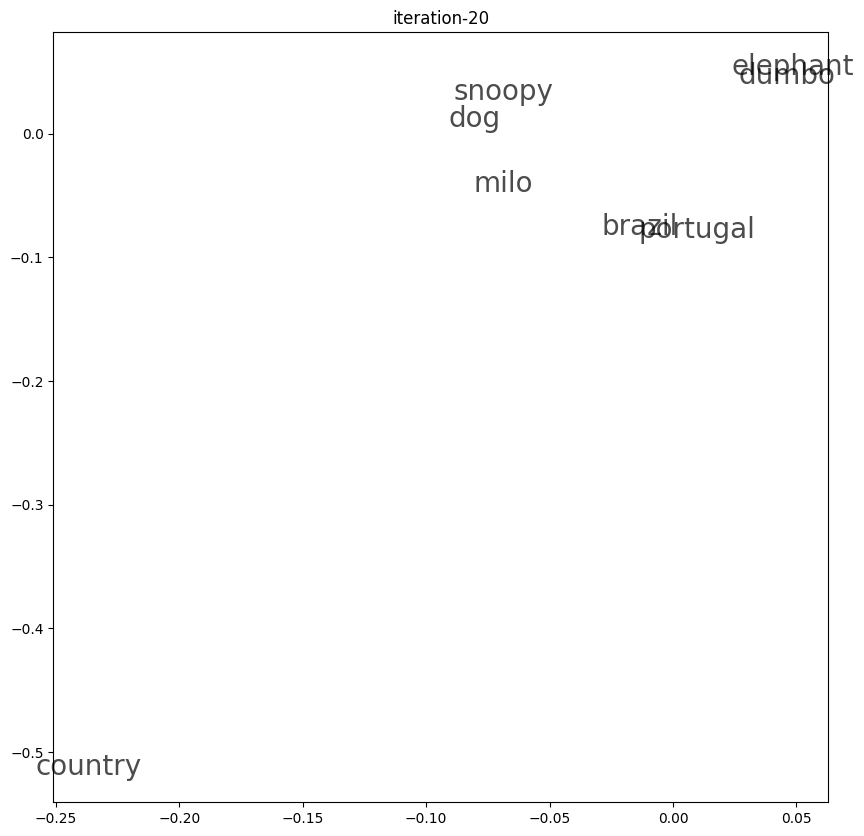

In [28]:
loss_hist = []

for i in range(20):

    if i > 0:

        content_words, context_words, labels = make_skipgrams()

        hist = model.fit([content_words, context_words], labels, epochs=1, verbose=0)
        print(f"loss: {hist.history['loss'][-1]:.4f}")
        loss_hist.extend(hist.history['loss'])

    embedding_vectors = np.array(embeddings.weights[0].numpy())

    fig, ax = plt.subplots(figsize=(10,10))

    ax.scatter(embedding_vectors[1:, 0], embedding_vectors[1:, 1],  c='white')

    for idx, word in sorted(tokenizer.index_word.items()):
        x_coord = embedding_vectors[idx, 0]
        y_coord = embedding_vectors[idx, 1]

        ax.annotate(
            word,
            (x_coord, y_coord),
            horizontalalignment='center',
            verticalalignment='center',
            size=20,
            alpha=0.7
        )

        ax.set_title(f"iteration-{i+1}")

    plt.savefig(f"iteration-{i+1:03d}.jpg")